# **Importing Libraries**

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms 
import torch.nn as nn  
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os
import shutil
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import DataLoader

# **Data Proccessing**

In [2]:
train_folders = sorted(glob.glob('data/natural_images/*'))

In [3]:
len(train_folders)

8

In [4]:
def load_image(image_path, resize = True):  
  img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
  
  return img

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

In [7]:
def show_batch_image(image_path):
  images = [load_image(img) for img in image_path]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow = 11)
  plt.figure(figsize = (15,15))
  plt.imshow(grid_img.permute(1, 2, 0))

In [8]:
sample_images = [np.random.choice(glob.glob(f'{tf}/*jpg')) for tf in train_folders]

C:\Users\vyshu\AppData\Local\Temp\ipykernel_11148\178872534.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_e1nmgx0bk6\croot\pytorch-select_1725478824526\work\torch\csrc\utils\tensor_new.cpp:277.)
  images = torch.as_tensor(images)


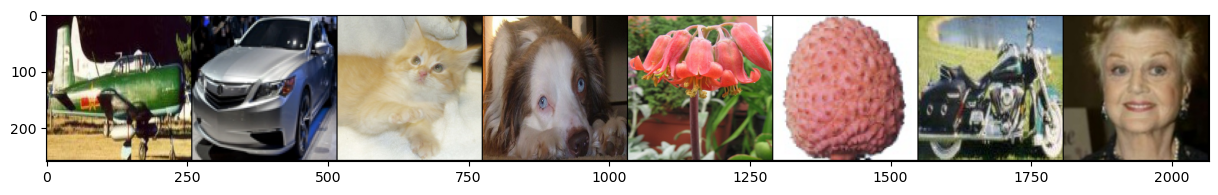

In [9]:
x = show_batch_image(sample_images)

In [10]:
class_names = ['Airplane', 'Car', 'Cat', 'Dog', 'Flower', 'Fruit', 'Motorbike', 'Person']
class_position = [0, 1, 2, 3, 4, 5, 6, 7]

In [11]:
os.makedirs('data/train', exist_ok = True)
os.makedirs('data/test', exist_ok = True)

for classes in class_names:
  os.makedirs(f'data/train/{classes}', exist_ok = True)
  os.makedirs(f'data/test/{classes}', exist_ok = True )

In [12]:
for i, cls_position in enumerate(class_position):
  image_paths = np.array(glob.glob(f'{train_folders[cls_position]}/*.jpg'))
  class_name = class_names[i]
  print(f'{class_name}:{len(image_paths)}')
  #np.random.shuffle(image_paths)
  train, test = train_test_split(image_paths, random_state = 0, shuffle = True)

  for img in train:
    shutil.copy(img, f'data/train/{class_name}')

  for img in test:
    shutil.copy(img, f'data/test/{class_name}')

Airplane:727
Car:968
Cat:885
Dog:702
Flower:843
Fruit:1000
Motorbike:788
Person:986


In [13]:
print(train.shape)
print(test.shape)

(739,)
(247,)


In [14]:
mean = [0.4914, 0.4822, 0.4465]
median = [0.2470, 0.2435, 0.2616]

chosen_transforms = {'train': transforms.Compose([
  transforms.RandomResizedCrop(size = 256),
  transforms.ToTensor(),
  transforms.Normalize(mean, median)
]),'test':transforms.Compose([
  transforms.Resize(size = 256),
  transforms.ToTensor(),
  transforms.Normalize(mean, median)
]),}

In [15]:
data_dir = 'data/'

sample_datasets = {
    x:torchvision.datasets.ImageFolder(os.path.join(data_dir, x), transform = chosen_transforms[x])
    for x in ['train', 'test']
}

In [16]:
dataloader = {x: DataLoader(sample_datasets[x], batch_size = 6, shuffle=True)
                for x in ['train', 'test'] }

In [17]:
print(type(dataloader['train']))

<class 'torch.utils.data.dataloader.DataLoader'>


In [18]:
dataiter = iter(dataloader['train'])  # Create an iterator
images, labels = next(dataiter)  # Correct way to get the next batch

print(images.shape)  # Print batch shape
print(images[1].shape)  # Print shape of one image
print(labels[1].item())  # Print label as a Python integer


torch.Size([6, 3, 256, 256])
torch.Size([3, 256, 256])
0


In [19]:
sample_dataset_sizes = {x: len(sample_datasets[x]) for x in ['train','test']}
true_sample_class_names = sample_datasets['train'].classes

In [20]:
def imshow(img, title):
  img = img.numpy().transpose(1,2,0)
  mean = np.array([0.4914, 0.4822, 0.4465])
  std = np.array([0.2470, 0.2435, 0.2616])
  img = std*img + mean
  img = np.clip(img, 0, 1)
  plt.figure(figsize=(8,4))
  plt.imshow(img)
  plt.axis('off')
  plt.title(title)
  plt.show()

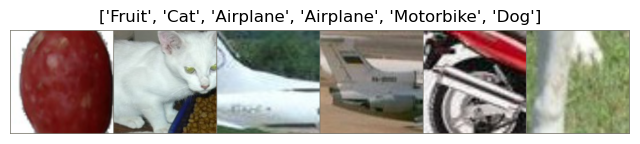

In [21]:
images, classes = next(iter(dataloader['train']))
imshow(torchvision.utils.make_grid(images), title = [true_sample_class_names[x] for x in classes])

In [22]:
image_dims = (256, 256)
batch_size = 4

In [23]:
def imshow_masked(img):
  npimg = img.numpy()
  plt.figure(figsize = (3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

In [24]:
class Dataset(torchvision.datasets.ImageFolder):
  def __init__(self, path, image_dims = (256, 256), n_channels = 3):
    super().__init__(path)
    self.n_classes = 8
    self.image_dims = image_dims
    self.n_channels = n_channels
    self.resize = transforms.Resize(image_dims)
    self.to_tensor = transforms.ToTensor()

  def __getitem__(self, index):
    image, label = super().__getitem__(index)

    Y_output = self.resize(image)
    X_input, X_mask = self.Create_Mask(Y_output)
    return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(Y_output)

  def Create_Mask(self, image):
    mask = np.full((self.image_dims[0], self.image_dims[1], self.n_channels), 255, dtype = np.uint8)

    for _ in range(np.random.randint(1, 10)):
      x1, x2 = np.random.randint(1, self.image_dims[0]), np.random.randint(1, self.image_dims[0])
      y1, y2 = np.random.randint(1, self.image_dims[1]), np.random.randint(1, self.image_dims[1])
      thickness = np.random.randint(10,13)

      cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

    image = np.asarray(image)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image, mask

In [25]:
Trainset = Dataset('data/train', image_dims)
Testset = Dataset('data/test', image_dims)

In [26]:
Trainloader = torch.utils.data.DataLoader(Trainset, batch_size = batch_size, shuffle = True)
Testloader = torch.utils.data.DataLoader(Testset, batch_size = batch_size, shuffle = False)

In [27]:
print(len(Trainloader))

1293


In [28]:
Train_dataiter = iter(Trainloader)

In [29]:
Test_dataiter = iter(Testloader)

In [30]:
X_in, X_mask, Y_out = next(Train_dataiter)  # Correct way to get the next batch
print(X_in.shape, X_mask.shape, Y_out.shape)  # Print shapes


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


Masked Image


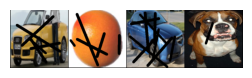

Masking Pattern


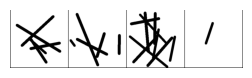

Original Image


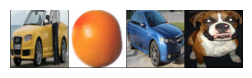

In [31]:
print('Masked Image')
imshow_masked(torchvision.utils.make_grid(X_in))
print('Masking Pattern')
imshow_masked(torchvision.utils.make_grid(X_mask))
print('Original Image')
imshow_masked(torchvision.utils.make_grid(Y_out))

# **Training**

In [32]:
layers = 7

In [33]:
class PartialConvLayer(nn.Module):
  def __init__(self, in_channels, out_channels, bn = True, bias = False, sample = "none-3", activation = "relu"):
    super().__init__()
    self.bn = bn
    self.activation = activation

    if sample == "down-7":
      self.input_conv = nn.Conv2d(in_channels, out_channels, 7, 2, 3, bias = bias)
      self.mask_conv = nn.Conv2d(in_channels, out_channels, 7, 2, 3, bias = False)

    elif sample == "down-5":
      self.input_conv = nn.Conv2d(in_channels, out_channels, 5, 2, 2, bias = bias)
      self.mask_conv = nn.Conv2d(in_channels, out_channels, 5, 2, 2, bias = False)

    elif sample == "down-3":
      self.input_conv = nn.Conv2d(in_channels, out_channels, 3, 2, 1, bias = bias)
      self.mask_conv = nn.Conv2d(in_channels, out_channels, 3, 2, 1, bias = False)
    
    else:
      self.input_conv = nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=bias)
      self.mask_conv = nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False)
      
    nn.init.constant_(self.mask_conv.weight, 1.0)
    nn.init.kaiming_normal_(self.input_conv.weight, a = 0, mode = "fan_in")

    for param in self.mask_conv.parameters():
      param.requires_grad = False

    if bn:
      self.batch_normalization = nn.BatchNorm2d(out_channels)

    if activation == "relu":
      self.activation = nn.ReLU()
    elif activation == "leaky_relu":
      self.activation == nn.LeakyReLU(negative_slope = 0.2)

  def forward(self, input_x, mask):
    output = self.input_conv(input_x * mask)
    with torch.no_grad():
      output_mask = self.mask_conv(mask)
    
    if self.input_conv.bias is not None:
      output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(output)
    else:
      output_bias = torch.zeros_like(output)

    mask_is_zero = (output_mask == 0)
    mask_sum = output_mask.masked_fill_(mask_is_zero, 1.0)

    output = (output - output_bias) / mask_sum + output_bias
    output = output.masked_fill(mask_is_zero, 0.0)

    new_mask = torch.ones_like(output)
    new_mask = new_mask.masked_fill_(mask_is_zero, 0.0)

    if self.bn:
      output = self.batch_normalization(output)
    #if hasattr(self, 'activation'):
      #output = self.activation(output)

    return output, new_mask

class PartialConvUNet(nn.Module):
  def __init__(self, input_size = 256, layer = 7):
    if 2**(layers + 1) != input_size:
      raise AssertionError

    super().__init__()
    self.freeze_enc_bn = False
    self.layers = layers

    self.encoder_1 = PartialConvLayer(3, 64, bn=False, sample="down-7")
    self.encoder_2 = PartialConvLayer(64, 128, sample="down-5")
    self.encoder_3 = PartialConvLayer(128, 256, sample="down-3")
    self.encoder_4 = PartialConvLayer(256, 512, sample="down-3")

    for i in range(5, layers + 1):
      name = "encoder_{:d}".format(i)
      setattr(self, name, PartialConvLayer(512, 512, sample="down-3"))
   
    for i in range(5, layers + 1):
      name = "decoder_{:d}".format(i)
      setattr(self, name, PartialConvLayer(512 + 512, 512, activation="leaky_relu"))
   
    self.decoder_4 = PartialConvLayer(512 + 256, 256, activation="leaky_relu")
    self.decoder_3 = PartialConvLayer(256 + 128, 128, activation="leaky_relu")
    self.decoder_2 = PartialConvLayer(128 + 64, 64, activation="leaky_relu")
    self.decoder_1 = PartialConvLayer(64 + 3, 3, bn=False, activation="", bias=True)

  def forward(self, input_x, mask):
    encoder_dict = {}
    mask_dict = {}
    key_prev = "h_0"
    encoder_dict[key_prev], mask_dict[key_prev] = input_x, mask

    for i in range(1, self.layers + 1):
      encoder_key = "encoder_{:d}".format(i)
      key = "h_{:d}".format(i)
      encoder_dict[key], mask_dict[key] = getattr(self, encoder_key)(encoder_dict[key_prev], mask_dict[key_prev])
      key_prev = key

    out_key = "h_{:d}".format(self.layers)
    out_data, out_mask = encoder_dict[out_key], mask_dict[out_key]

    for i in range(self.layers, 0, -1):
      encoder_key = "h_{:d}".format(i - 1)
      decoder_key = "decoder_{:d}".format(i)
      out_data = F.interpolate(out_data, scale_factor=2)
      out_mask = F.interpolate(out_mask, scale_factor=2)
      out_data = torch.cat([out_data, encoder_dict[encoder_key]], dim=1)
      out_mask = torch.cat([out_mask, mask_dict[encoder_key]], dim=1)
      out_data, out_mask = getattr(self, decoder_key)(out_data, out_mask)
    return out_data

  def train(self, mode=True):
    super().train(mode)
    if self.freeze_enc_bn:
      for name, module in self.named_modules():
        if isinstance(module, nn.BatchNorm2d) and "enc" in name:
          module.eval()

In [34]:
def Dice_coeff(dataloader):
  for (X_input, X_mask, Y_output) in dataloader:
    X_input, X_mask, Y_output = X_input.to(device), X_mask.to(device), Y_output.to(device)
    outputs = model(X_input, X_mask)
    eps = 1e-15
    outputs = outputs.view(-1)
    Y_output = Y_output.view(-1)
    intersection = (outputs * Y_output).sum()
    sum = (outputs.sum() + Y_output.sum())
  return (2*(intersection) / (sum + eps))

In [35]:
model = PartialConvUNet().to(device)
model = model.to(device)

In [36]:
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters())

Min loss 0.45
Iteration: 0/12500, Loss: 0.45
Min loss 0.25
Min loss 0.20
Min loss 0.17
Min loss 0.16
Min loss 0.13
Min loss 0.12
Min loss 0.07
Iteration: 100/12500, Loss: 0.14
Min loss 0.04
Min loss 0.04
Min loss 0.03
Iteration: 200/12500, Loss: 0.03
Min loss 0.03
Min loss 0.02
Min loss 0.02
Min loss 0.02
Min loss 0.01
Min loss 0.01
Iteration: 300/12500, Loss: 0.04
Iteration: 400/12500, Loss: 0.02
Min loss 0.01
Iteration: 500/12500, Loss: 0.01
Iteration: 600/12500, Loss: 0.03
Iteration: 700/12500, Loss: 0.02
Min loss 0.01
Iteration: 800/12500, Loss: 0.01
Min loss 0.01
Min loss 0.01
Min loss 0.01
Min loss 0.01
Iteration: 900/12500, Loss: 0.01
Min loss 0.01
Min loss 0.01
Iteration: 1000/12500, Loss: 0.03
Min loss 0.00
Min loss 0.00
Iteration: 1100/12500, Loss: 0.02
Min loss 0.00
Iteration: 1200/12500, Loss: 0.01
Min loss 0.00
Iteration: 0/12500, Loss: 0.01
Iteration: 100/12500, Loss: 0.01
Iteration: 200/12500, Loss: 0.02
Iteration: 300/12500, Loss: 0.01
Min loss 0.00
Iteration: 400/12500

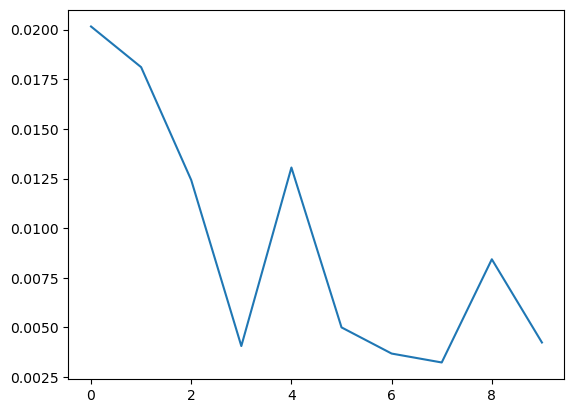

In [37]:
loss_epoch_arr = []
max_epochs = 10

min_loss = 1000

n_iters = np.ceil(50000/batch_size)
for epoch in range(max_epochs):
    model.train()                               
    for i, (X_input, X_mask, Y_output) in enumerate(Trainloader, 0):

        X_input, X_mask, Y_output = X_input.to(device), X_mask.to(device), Y_output.to(device)

        opt.zero_grad()

        outputs = model(X_input, X_mask)
        loss = loss_fn(Y_output, outputs)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.002f' % (i, n_iters, loss.item()))
            
        del X_input, X_mask, Y_output
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
plt.plot(loss_epoch_arr)
plt.show()

In [38]:
model.load_state_dict(best_model)

<All keys matched successfully>

# **Testing**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


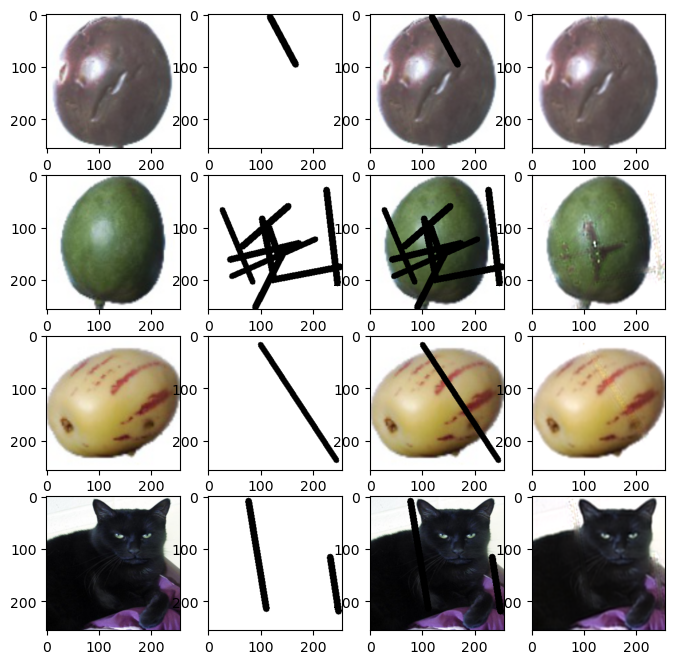

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU if available
model.to(device)

# Get batch from the dataloader
sample_inputs, sample_masks, sample_truths = next(iter(Train_dataiter))

# Move tensors to the same device
sample_inputs, sample_masks = sample_inputs.to(device), sample_masks.to(device)

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

# Move everything back to CPU for visualization
sample_inputs, sample_masks, sample_preds = sample_inputs.cpu(), sample_masks.cpu(), sample_preds.cpu()

# Plot
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i].numpy(), (1, 2, 0)))  # Ensure numpy conversion
    axs[i][1].imshow(np.transpose(sample_masks[i].numpy(), (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i].numpy(), (1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].numpy(), (1, 2, 0)))

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


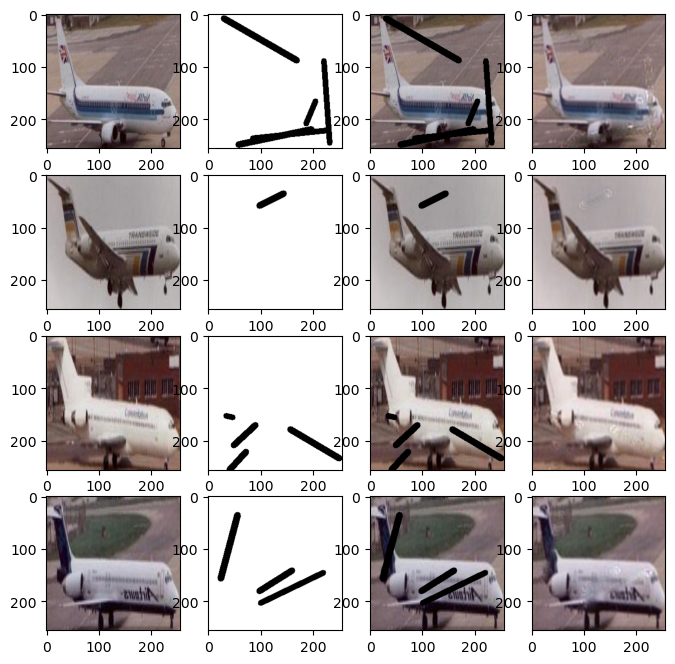

In [90]:
sample_inputs, sample_masks, sample_truths = next(Test_dataiter)

# Move data to CPU (remove .cuda() calls)
sample_inputs, sample_masks = sample_inputs.to("cpu"), sample_masks.to("cpu")

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Convert tensors to NumPy for visualization
sample_inputs, sample_masks = sample_inputs.numpy(), sample_masks.numpy()
sample_preds = sample_preds.numpy()

for i in range(min(4, len(sample_inputs))):  # Avoid index errors
    axs[i][0].imshow(np.transpose(sample_truths[i].numpy(), (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i], (1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i], (1, 2, 0)))

plt.show()


# **Evaluation**

In [182]:
def load_image(image_path, resize = True):  
  img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
  
  return img

In [183]:
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

In [184]:
def masking(image):

  Y_output = transforms.Resize((256, 256))

  mask = np.full((256, 256, 3), 255, dtype = np.uint8)

  for _ in range(np.random.randint(1, 5)):
    x1, x2 = np.random.randint(1, 256), np.random.randint(1, 256)
    y1, y2 = np.random.randint(1, 256), np.random.randint(1, 256)
    thickness = np.random.randint(2,10)

    cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

  image = np.asarray(image)
  masked_image = cv2.bitwise_and(image, mask)
  masked_image, mask
  
  X_input, X_mask = masked_image, mask
  X_input = Image.fromarray(X_input)
  X_mask = Image.fromarray(X_mask)
  return X_input, X_mask

In [185]:
def Inpaint(masked_image, mask):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    
    masked_image = torch.from_numpy(masked_image)
    masked_image = torch.as_tensor(masked_image, dtype=torch.float64)
    masked_image = transforms.Normalize(mean, std)(masked_image)
    
    mask = torch.from_numpy(mask)
    mask = torch.as_tensor(mask, dtype=torch.float64)
    mask = transforms.Normalize(mean, std)(mask)
    
    # No need to move tensors to GPU
    # masked_image, mask = masked_image.cuda(), mask.cuda()
    
    model.eval()
    with torch.no_grad():
        # Run on CPU
        predicted_image = model(masked_image[None].float(), mask[None].float())
        predicted_image = predicted_image.cpu()  # Already on CPU, but this is safe to keep
        print(predicted_image.shape)
        pred = predicted_image.squeeze()
        print(pred.shape)
        pred1 = pred.numpy()
        print(pred1.shape)
        pred2 = np.transpose(pred1, (1, 2, 0))
        pred3 = std * pred2 + mean
        plt.imshow((pred3 / 2).astype(np.uint16))

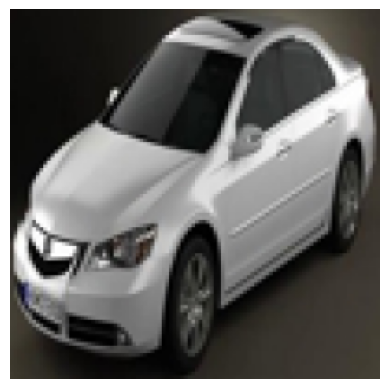

In [186]:
show_image('data\\test\\Car\\car_0001.jpg')

In [187]:
sample_image = load_image('data\\test\\Car\\car_0001.jpg')
tran = transforms.ToPILImage()
sample_image = tran(sample_image)

In [188]:
X_input, X_mask = masking(sample_image)

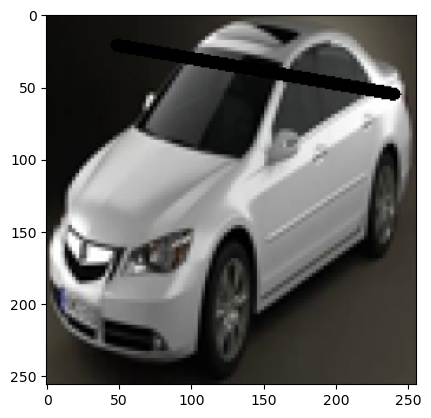

In [189]:
X_input = np.asarray(X_input)
plt.imshow(X_input)
plt.show()

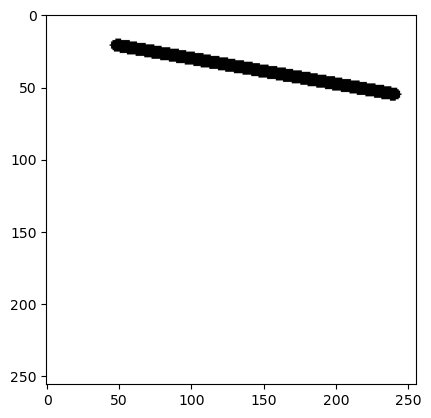

In [190]:
X_mask = np.asarray(X_mask)
plt.imshow(X_mask)
plt.show()

In [191]:
X_input1 = np.transpose(X_input,(2, 0, 1))
print(X_input1.shape)

(3, 256, 256)


In [192]:
X_mask1 = np.transpose(X_mask,(2, 0, 1))
print(X_mask1.shape)

(3, 256, 256)


torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])
(3, 256, 256)


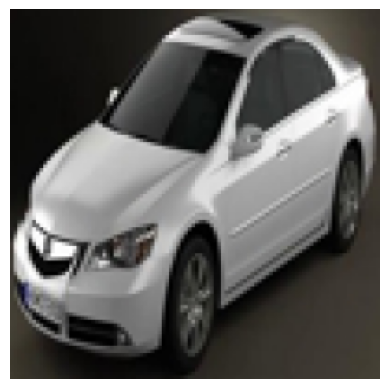

In [ ]:
Inpaint(X_input1, X_mask1)